## CS484 Final Project: Semi-supervised Image Classification

**Name:** Sirius Hou  
**Email:** y45hou@uwaterloo.ca



### Abstract

(outlining the high-level goal and discussing well-motivated methodology of the project.)

### \*Potential Projects

- **Project 2 (+) High-dynamic range imaging:** Implement Debevec-Malik method, e.g. see section 10.2 in Szeliski's book for details. You can use examples from here. Once you test your implementation on bracketed image sequences taken on a tripod, you can try to extend your method to multi-exposure images taken without a tripod using homography-based registration of the sequence. Try to drop the assumption of known exposure.

- **Project 4 (+) Deep features for interactive segmentation:** implement interactive segmenation tool (e.g. graph cuts) replacing low-level features (raw colors) with deep features produced by representation/embedding models (e.g. imageNET pretrained features, or DINO features or others).

- **Project 5 (++) Semi-supervised image classification:** assuming that only M out of N images in the traingin data have ground truth labels, design and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in the training dataset (e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples). You should demonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one basic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep features (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss enforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function formulated in Bridle & MacKay "Unsupervised Classifiers, Mutual Information and Phantom Targets", NIPS 1991.


- 



### Team Members & Contributions

- Member 1: Sirius Hou (y45hou@uwaterloo.ca)  
- Member 2: Emily Chen (e94chen@uwaterloo.ca)

### Code Libraries

- acknowledging all external code libraries "essential" for your project.
- You should explain the importance of each such library for your project.
- If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory.
- \*If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory.

### Conclusions

(a cell with two-three paragraphs summarizing the conclusions of your project)

### Motivation
In this project, we explore semi-supervised learning, where only a small subset $M$ out of $N$ total training samples have labels. This is a common setting in real-world applications where collecting labels is expensive or time-consuming.

We will use the MNIST dataset, which consists of 60,000 grayscale digit images (28×28). Since the VGG11 network requires a consistent input resolution across tasks (as it expects input like ImageNet), we resize images to 32×32.

#### Step 1: Imports and Configs

Our goal in this step is to:

- Download and preprocess the MNIST dataset.

- Randomly sample M labeled images in a class-balanced way (i.e., M/10 per class).

- Create two datasets:

  - Labeled set: Contains images and labels, used for supervised loss.
  - Unlabeled set: Contains images only; labels are hidden and will not be used during training.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.cluster import KMeans
import torch.nn as nn
import random

# Configuration
M = 1000                    # Number of labeled samples
batch_size = 256
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Set random seeds for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


Using device: cuda


#### Transform and Load MNIST
We use transforms.Resize((32, 32)) to fit VGG11 input requirements and normalize the pixel values to tensors.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)



#### Split Dataset into Labeled and Unlabeled
We randomly choose M labeled images in a class-balanced way (i.e., M/10 per digit class). The remaining samples will form the unlabeled set.

In [3]:
def split_labeled_unlabeled(dataset, M):
    targets = np.array(dataset.targets)
    labeled_indices = []
    unlabeled_indices = []

    samples_per_class = M // 10

    for class_id in range(10):
        class_indices = np.where(targets == class_id)[0]
        selected = np.random.choice(class_indices, samples_per_class, replace=False)
        labeled_indices.extend(selected)

    all_indices = set(range(len(dataset)))
    unlabeled_indices = list(all_indices - set(labeled_indices))

    labeled_set = Subset(dataset, labeled_indices)
    unlabeled_set = Subset(dataset, unlabeled_indices)

    return labeled_set, unlabeled_set


#### Build DataLoaders
We now split the dataset and build data loaders for both labeled and unlabeled subsets.

In [4]:
labeled_dataset, unlabeled_dataset = split_labeled_unlabeled(train_dataset, M)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)


#### Visualize the Split
To verify the correctness of our data split, we display a few samples from both the labeled and unlabeled datasets.

Labeled dataset size: 1000
Unlabeled dataset size: 59000


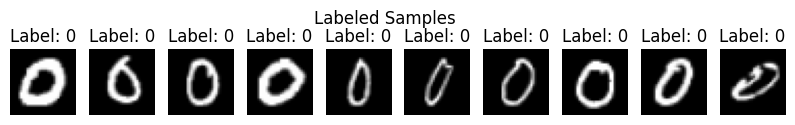

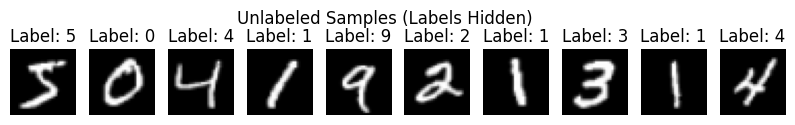

In [5]:
def show_samples(dataset, title, n=10):
    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

print(f"Labeled dataset size: {len(labeled_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")

# Show samples
show_samples(labeled_dataset, title="Labeled Samples")
show_samples(unlabeled_dataset, title="Unlabeled Samples (Labels Hidden)")


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reuse your VGG11 model class
class VGG11(nn.Module):
    def __init__(self, return_features=False):
        super(VGG11, self).__init__()
        self.return_features = return_features

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x, return_features=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        features = self.classifier[:-1](x)
        logits = self.classifier[-1](features)
        if return_features or self.return_features:
            return logits, features
        return logits

# Create model instance
model = VGG11().to(device)


Using device: cuda


In [5]:
# Resize only (keep PIL.Image)
transform_resize = transforms.Resize((32, 32))

# For labeled data: basic ToTensor
transform_labeled = transforms.ToTensor()

# For unlabeled data: strong augmentation
transform_unlabeled_aug = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_resize)

def split_labeled_unlabeled(dataset, M):
    targets = np.array(dataset.targets)
    labeled_indices = []
    samples_per_class = M // 10

    for class_id in range(10):
        class_indices = np.where(targets == class_id)[0]
        selected = np.random.choice(class_indices, samples_per_class, replace=False)
        labeled_indices.extend(selected)

    all_indices = set(range(len(dataset)))
    unlabeled_indices = list(all_indices - set(labeled_indices))

    return Subset(dataset, labeled_indices), Subset(dataset, unlabeled_indices)

labeled_dataset, unlabeled_dataset = split_labeled_unlabeled(train_dataset, M)





In [6]:
class UnlabeledDatasetWrapper(Dataset):
    def __init__(self, dataset, transform=None, strong_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.strong_transform = strong_transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # PIL Image
        if self.strong_transform:
            img1 = self.strong_transform(img)
            img2 = self.strong_transform(img)
            return img1, img2, -1
        else:
            img = self.transform(img)
            return img, -1

    def __len__(self):
        return len(self.dataset)


In [7]:
labeled_dataset_wrapped = UnlabeledDatasetWrapper(labeled_dataset, transform=transform_labeled)
unlabeled_dataset_wrapped = UnlabeledDatasetWrapper(unlabeled_dataset, transform=transform_labeled, strong_transform=transform_unlabeled_aug)

labeled_loader = DataLoader(labeled_dataset_wrapped, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset_wrapped, batch_size=batch_size, shuffle=True)


In [8]:
def extract_features(model, data_loader, device):
    model.eval()
    all_features = []
    with torch.no_grad():
        for inputs, *_ in data_loader:
            inputs = inputs.to(device)
            _, features = model(inputs, return_features=True)
            all_features.append(features.cpu())
    return torch.cat(all_features, dim=0)

def compute_kmeans_centroids(features, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features.numpy())
    centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    assignments = kmeans.labels_
    return centroids, assignments

def kmeans_loss(features, assignments, centroids):
    assigned_centroids = centroids[assignments]
    return nn.MSELoss()(features, assigned_centroids)

def consistency_loss(p1, p2, mode="mse"):
    if mode == "mse":
        return nn.MSELoss()(p1, p2)
    elif mode == "kl":
        p1 = torch.log_softmax(p1, dim=1)
        p2 = torch.softmax(p2, dim=1)
        return nn.KLDivLoss(reduction='batchmean')(p1, p2)


Labeled dataset size: 1000
Unlabeled dataset size: 59000


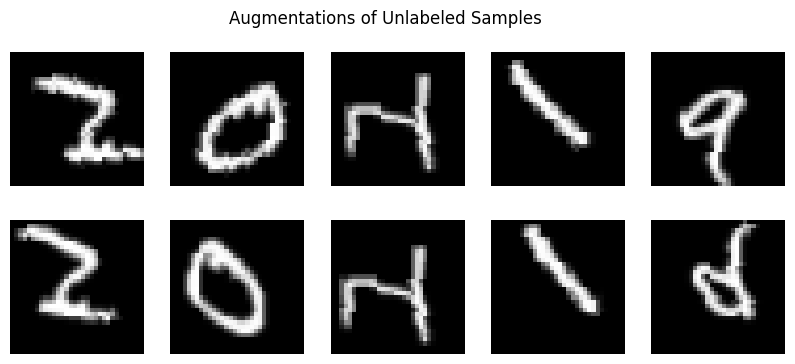

In [9]:
def show_augmented_samples(dataset, title, n=5):
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        img1, img2, _ = dataset[i]
        axes[0, i].imshow(img1.squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(img2.squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Aug1", size=12)
    axes[1, 0].set_ylabel("Aug2", size=12)
    plt.suptitle(title)
    plt.show()

print(f"Labeled dataset size: {len(labeled_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")

show_augmented_samples(unlabeled_dataset_wrapped, title="Augmentations of Unlabeled Samples")


In [10]:
import torch.optim as optim

# Hyperparameters
num_epochs = 10
lr = 0.001
lambda_kmeans = 1.0
lambda_consistency = 10.0
num_clusters = 10

criterion_sup = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # optional

def train_semi_supervised(model, labeled_loader, unlabeled_loader, device):
    model.train()
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Step 1: Extract features from all unlabeled data
        print("Extracting features from unlabeled data for KMeans clustering...")
        features = extract_features(model, unlabeled_loader, device)
        centroids, assignments = compute_kmeans_centroids(features, num_clusters)
        centroids = centroids.to(device)
        assignments = torch.tensor(assignments, dtype=torch.long)

        running_loss = 0.0

        # Step 2: Train over both labeled and unlabeled data
        for (x_l, y_l), (x_u1, x_u2, _) in zip(labeled_loader, unlabeled_loader):
            
            x_l, y_l = x_l.to(device), y_l.to(device)
            x_u1, x_u2 = x_u1.to(device), x_u2.to(device)

            # Labeled Forward
            out_l = model(x_l)
            loss_sup = criterion_sup(out_l, y_l)

            # Unlabeled Forward (KMeans Loss)
            _, features_u = model(x_u1, return_features=True)

            # Map batch idx to global idx (simple way: random shuffle loader should roughly align)
            batch_size_u = x_u1.size(0)
            batch_assignments = assignments[:batch_size_u].to(device)

            loss_kmeans = kmeans_loss(features_u, batch_assignments, centroids)

            # Consistency Loss
            out_u1 = model(x_u1)
            out_u2 = model(x_u2)
            loss_consistency = consistency_loss(out_u1, out_u2, mode="mse")

            # Total Loss
            loss = loss_sup + lambda_kmeans * loss_kmeans + lambda_consistency * loss_consistency

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        
        avg_loss = running_loss / len(labeled_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    print("Training finished!")


In [ ]:
model = VGG11().to(device)  # fresh model

print(device)
train_semi_supervised(model, labeled_loader, unlabeled_loader, device)


cuda
Epoch [1/10]
Extracting features from unlabeled data for KMeans clustering...


c:\Users\Sirius.DESKTOP-CNVN78J\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

# \*\*\* COPIED CODE FROM CS480

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

In [2]:
batch_size = 256
num_epochs = 5
lr=0.005

In [5]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).double().sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).double().sum().item()
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')
        
        train_loss, train_acc = avg_train_loss, 100.0 * correct / len(train_loader.dataset)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Train Accuracy: {train_acc:.2f}%')
        print(f'Test Accuracy: {test_acc:.2f}%\n')
    
    print("Training complete.")
    return train_losses, train_accuracies, test_losses, test_accuracies

def test_model(model, test_loader, device):
    _, accuracy = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("Using GPU")
else:
    print("Using CPU")


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


Using GPU


Epoch [1/5], Step [100/235], Loss: 1.8211
Epoch [1/5], Step [200/235], Loss: 1.1429
Epoch [1/5], Average Train Loss: 2.2800
Epoch [1/5]:
Train Accuracy: 32.34%
Test Accuracy: 73.83%

Epoch [2/5], Step [100/235], Loss: 0.6701
Epoch [2/5], Step [200/235], Loss: 0.4599
Epoch [2/5], Average Train Loss: 0.6085
Epoch [2/5]:
Train Accuracy: 79.36%
Test Accuracy: 92.94%

Epoch [3/5], Step [100/235], Loss: 0.2398
Epoch [3/5], Step [200/235], Loss: 0.1041
Epoch [3/5], Average Train Loss: 0.2681
Epoch [3/5]:
Train Accuracy: 93.40%
Test Accuracy: 26.47%

Epoch [4/5], Step [100/235], Loss: 0.1249
Epoch [4/5], Step [200/235], Loss: 0.1035
Epoch [4/5], Average Train Loss: 0.1866
Epoch [4/5]:
Train Accuracy: 95.65%
Test Accuracy: 98.05%

Epoch [5/5], Step [100/235], Loss: 0.0834
Epoch [5/5], Step [200/235], Loss: 0.0831
Epoch [5/5], Average Train Loss: 0.0970
Epoch [5/5]:
Train Accuracy: 97.72%
Test Accuracy: 98.03%

Training complete.


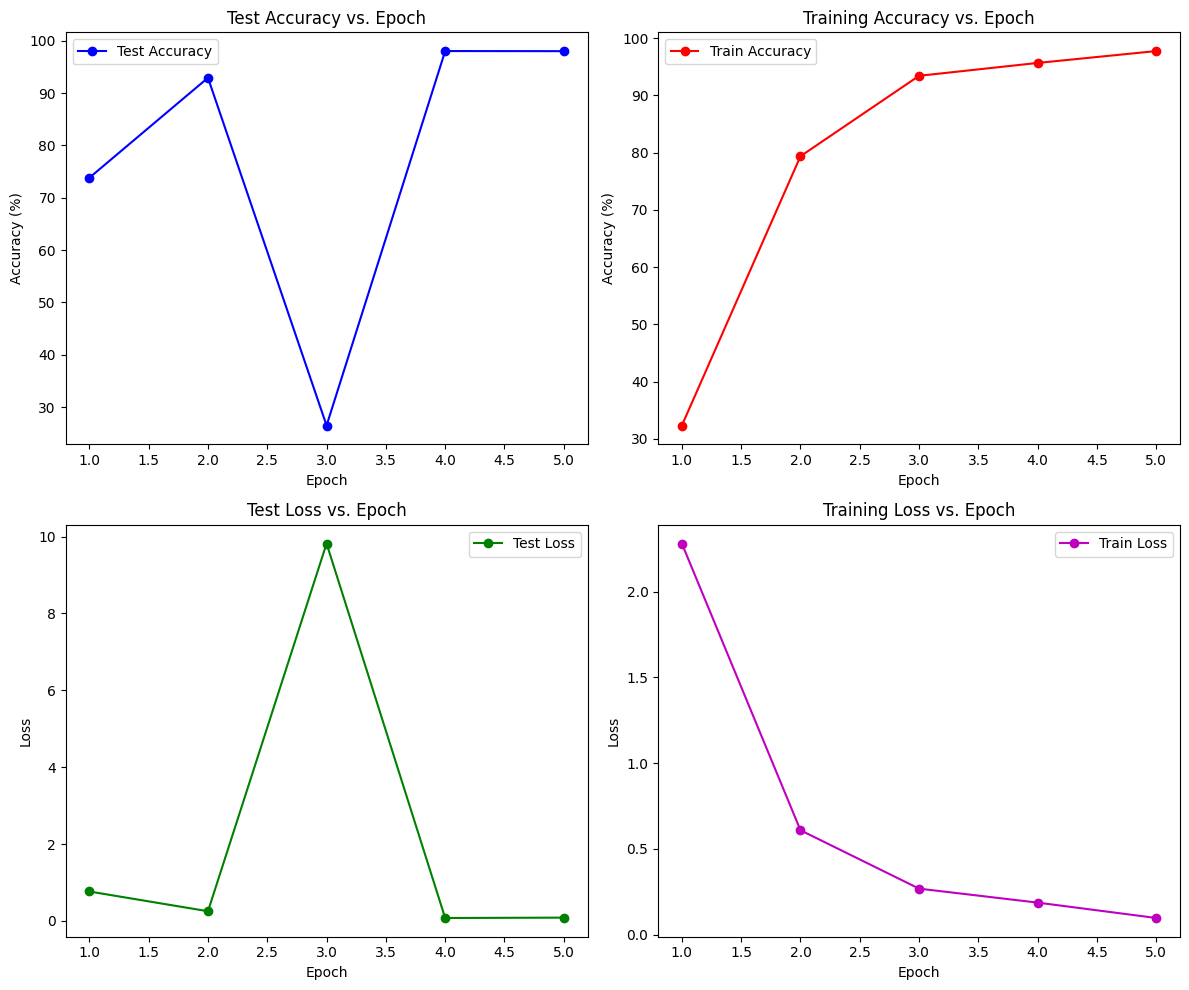

Accuracy of the network on the test images: 98.03%


In [6]:
num_epochs = 5
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

epochs = range(1, num_epochs+1)

# Test Accuracy vs Epochs
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(epochs, test_accuracies, 'bo-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Epoch')
plt.legend()

# Training Accuracy vs Epochs
plt.subplot(2,2,2)
plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.legend()

# Test Loss vs Epochs
plt.subplot(2,2,3)
plt.plot(epochs, test_losses, 'go-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs. Epoch')
plt.legend()

# Training Loss vs Epochs
plt.subplot(2,2,4)
plt.plot(epochs, train_losses, 'mo-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
test_model(model, test_loader, device)

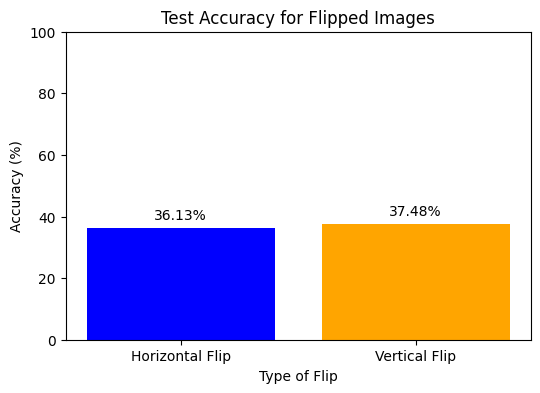

In [7]:
transform_hflip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
])

transform_vflip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor()
])

test_dataset_hflip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_hflip)
test_dataset_vflip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_vflip)

test_loader_hflip = torch.utils.data.DataLoader(dataset=test_dataset_hflip, batch_size=batch_size, shuffle=False)
test_loader_vflip = torch.utils.data.DataLoader(dataset=test_dataset_vflip, batch_size=batch_size, shuffle=False)


_, acc1 = evaluate(model, test_loader_hflip, criterion, device)
_, acc2 = evaluate(model, test_loader_vflip, criterion, device)


plt.figure(figsize=(6, 4))
bars = plt.bar(["Horizontal Flip", "Vertical Flip"], [acc1, acc2], color=['blue', 'orange'])
plt.xlabel('Type of Flip')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for Flipped Images')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()


**Effect:**

We observed that after the flips (both horizontally and vertically), the test accuracies drop significantly.

Evaluating model on test images with Variance=0.01:
Accuracy: 94.15%

Evaluating model on test images with Variance=0.1:
Accuracy: 24.29%

Evaluating model on test images with Variance=1:
Accuracy: 10.10%



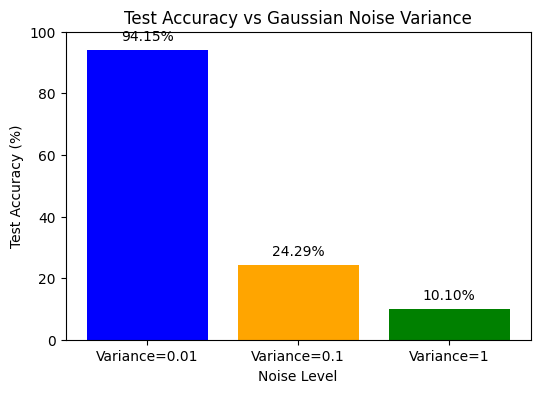

In [8]:
def noise_transform(var):
    return transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + math.sqrt(var) * torch.randn_like(x))
    ])


variances = [0.01, 0.1, 1.0]
noise_labels = ["Variance=0.01", "Variance=0.1", "Variance=1"]

noise_accuracies = []

for var, label in zip(variances, noise_labels):
    transform_noise = noise_transform(var)
    test_dataset_noise = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_noise)
    test_loader_noise = torch.utils.data.DataLoader(
        dataset=test_dataset_noise, batch_size=batch_size, shuffle=False)
    
    print(f"Evaluating model on test images with {label}:")
    loss_noise, acc_noise = evaluate(model, test_loader_noise, criterion, device)
    print(f"Accuracy: {acc_noise:.2f}%\n")
    noise_accuracies.append(acc_noise)

plt.figure(figsize=(6,4))
bars = plt.bar(noise_labels, noise_accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Gaussian Noise Variance')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()


**Effect:**

We observed that after adding Gaussian noise to test images, the test accuracies drop significally. For larger variance, the drop is much more significantly.

Epoch [1/5], Step [100/235], Loss: 2.1953
Epoch [1/5], Step [200/235], Loss: 1.9140
Epoch [1/5], Average Train Loss: 2.7020
Epoch [1/5]:
Train Accuracy: 19.53%
Test Accuracy: 17.88%

Epoch [2/5], Step [100/235], Loss: 1.5696
Epoch [2/5], Step [200/235], Loss: 1.5530
Epoch [2/5], Average Train Loss: 1.6198
Epoch [2/5]:
Train Accuracy: 39.88%
Test Accuracy: 21.35%

Epoch [3/5], Step [100/235], Loss: 1.2389
Epoch [3/5], Step [200/235], Loss: 0.8818
Epoch [3/5], Average Train Loss: 1.1625
Epoch [3/5]:
Train Accuracy: 61.60%
Test Accuracy: 64.37%

Epoch [4/5], Step [100/235], Loss: 0.9610
Epoch [4/5], Step [200/235], Loss: 0.9403
Epoch [4/5], Average Train Loss: 0.9181
Epoch [4/5]:
Train Accuracy: 71.83%
Test Accuracy: 83.24%

Epoch [5/5], Step [100/235], Loss: 0.7537
Epoch [5/5], Step [200/235], Loss: 1.1402
Epoch [5/5], Average Train Loss: 0.9134
Epoch [5/5]:
Train Accuracy: 72.68%
Test Accuracy: 90.84%

Training complete.


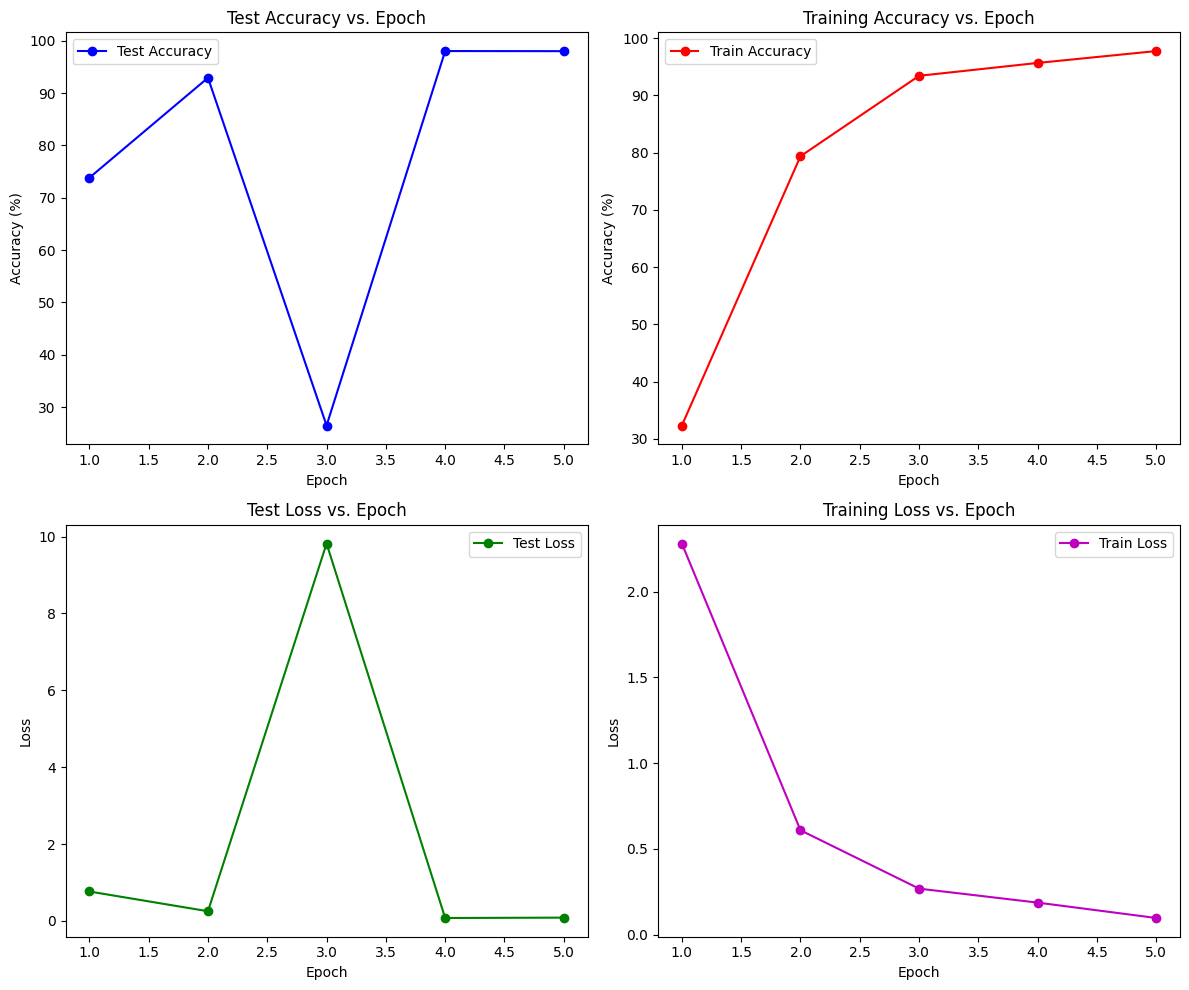

Final evaluation on original test set after retraining with augmentation:
Accuracy of the network on the test images: 90.84%


In [9]:
transform_train_aug = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), 
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.Lambda(lambda x : x + math.sqrt(variances[0]) * torch.randn_like(x)),
    transforms.Lambda(lambda x : x + math.sqrt(variances[1]) * torch.randn_like(x)),
    transforms.Lambda(lambda x : x + math.sqrt(variances[2]) * torch.randn_like(x)), 
    transforms.Lambda(lambda x : x)
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset_aug = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train_aug)
train_loader_aug = torch.utils.data.DataLoader(dataset=train_dataset_aug, batch_size=batch_size, shuffle=True)

model_aug = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=lr)

train_losses_aug, train_accuracies_aug, test_losses_aug, test_accuracies_aug = train_model(
    model_aug, train_loader_aug, test_loader, criterion, optimizer_aug, device, num_epochs=num_epochs
)

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(epochs, test_accuracies, 'bo-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Epoch')
plt.legend()

# Training Accuracy vs Epochs
plt.subplot(2,2,2)
plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.legend()

# Test Loss vs Epochs
plt.subplot(2,2,3)
plt.plot(epochs, test_losses, 'go-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs. Epoch')
plt.legend()

# Training Loss vs Epochs
plt.subplot(2,2,4)
plt.plot(epochs, train_losses, 'mo-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


print("Final evaluation on original test set after retraining with augmentation:")
test_model(model_aug, test_loader, device)

In [ ]:
_, acc1 = evaluate(model_aug, test_loader_hflip, criterion, device)
_, acc2 = evaluate(model_aug, test_loader_vflip, criterion, device)

plt.figure(figsize=(6, 4))
bars = plt.bar(["Horizontal Flip", "Vertical Flip"], [acc1, acc2], color=['blue', 'orange'])
plt.xlabel('Type of Flip')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for Flipped Images')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()

In [ ]:
variances = [0.01, 0.1, 1.0]
noise_labels = ["Variance=0.01", "Variance=0.1", "Variance=1"]

noise_accuracies = []

for var, label in zip(variances, noise_labels):
    transform_noise = noise_transform(var)
    test_dataset_noise = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_noise)
    test_loader_noise = torch.utils.data.DataLoader(
        dataset=test_dataset_noise, batch_size=batch_size, shuffle=False)
    
    print(f"Evaluating model on test images with {label}:")
    loss_noise, acc_noise = evaluate(model_aug, test_loader_noise, criterion, device)
    print(f"Accuracy: {acc_noise:.2f}%\n")
    noise_accuracies.append(acc_noise)

plt.figure(figsize=(6,4))
bars = plt.bar(noise_labels, noise_accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Gaussian Noise Variance')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()

The data augmentation strategy I use is that I randomly select one transform from the flips (horizontal/vertical) and adding Gaussion noise with different variances (1/0.1/0.01) and apply to the dataset. Therefore, the model is trained on more diverse samples and became more robust to those variances.

In [ ]:
### CS480 A2 BACKUP

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import math

# batch_size = 256
# num_epochs = 5
# lr=0.005

# class VGG11(nn.Module):
#     def __init__(self):
#         super(VGG11, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 1 * 1, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 10)
#         )
    
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# def evaluate(model, data_loader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * labels.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).double().sum().item()
#             total += labels.size(0)
#     avg_loss = total_loss / total
#     accuracy = 100.0 * correct / total
#     return avg_loss, accuracy


# def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         for i, (inputs, labels) in enumerate(train_loader):
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).double().sum().item()
#             if (i+1) % 100 == 0:
#                 print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
#         avg_train_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')
        
#         train_loss, train_acc = avg_train_loss, 100.0 * correct / len(train_loader.dataset)
#         test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
#         train_losses.append(train_loss)
#         train_accuracies.append(train_acc)
#         test_losses.append(test_loss)
#         test_accuracies.append(test_acc)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}]:')
#         print(f'Train Accuracy: {train_acc:.2f}%')
#         print(f'Test Accuracy: {test_acc:.2f}%\n')
    
#     print("Training complete.")
#     return train_losses, train_accuracies, test_losses, test_accuracies

# def test_model(model, test_loader, device):
#     _, accuracy = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
#     print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if device.type == "cuda":
#     print("Using GPU")
# else:
#     print("Using CPU")


# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor()
# ])


# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# model = VGG11().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)


# num_epochs = 5
# train_losses, train_accuracies, test_losses, test_accuracies = train_model(
#     model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

# epochs = range(1, num_epochs+1)

# # Test Accuracy vs Epochs
# plt.figure(figsize=(12, 10))
# plt.subplot(2,2,1)
# plt.plot(epochs, test_accuracies, 'bo-', label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Test Accuracy vs. Epoch')
# plt.legend()

# # Training Accuracy vs Epochs
# plt.subplot(2,2,2)
# plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Training Accuracy vs. Epoch')
# plt.legend()

# # Test Loss vs Epochs
# plt.subplot(2,2,3)
# plt.plot(epochs, test_losses, 'go-', label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss vs. Epoch')
# plt.legend()

# # Training Loss vs Epochs
# plt.subplot(2,2,4)
# plt.plot(epochs, train_losses, 'mo-', label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss vs. Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Final evaluation on test set
# test_model(model, test_loader, device)


# Epoch [1/5], Step [100/235], Loss: 1.9634
# Epoch [1/5], Step [200/235], Loss: 1.3686
# Epoch [1/5], Average Train Loss: 2.3150
# Epoch [1/5]:
# Train Accuracy: 27.58%
# Test Accuracy: 34.62%

# Epoch [2/5], Step [100/235], Loss: 1.1934
# Epoch [2/5], Step [200/235], Loss: 0.7599
# Epoch [2/5], Average Train Loss: 0.9637
# Epoch [2/5]:
# Train Accuracy: 62.25%
# Test Accuracy: 88.06%

# Epoch [3/5], Step [100/235], Loss: 0.3277
# Epoch [3/5], Step [200/235], Loss: 0.1372
# Epoch [3/5], Average Train Loss: 0.2933
# Epoch [3/5]:
# Train Accuracy: 92.53%
# Test Accuracy: 96.51%

# Epoch [4/5], Step [100/235], Loss: 0.1963
# Epoch [4/5], Step [200/235], Loss: 0.3222
# Epoch [4/5], Average Train Loss: 0.2703
# Epoch [4/5]:
# ...
# Train Accuracy: 97.70%
# Test Accuracy: 97.23%

# Training complete.


# Accuracy of the network on the test images: 97.23%


# transform_hflip = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.ToTensor()
# ])

# transform_vflip = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomVerticalFlip(p=1),
#     transforms.ToTensor()
# ])

# test_dataset_hflip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_hflip)
# test_dataset_vflip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_vflip)

# test_loader_hflip = torch.utils.data.DataLoader(dataset=test_dataset_hflip, batch_size=batch_size, shuffle=False)
# test_loader_vflip = torch.utils.data.DataLoader(dataset=test_dataset_vflip, batch_size=batch_size, shuffle=False)


# _, acc1 = evaluate(model, test_loader_hflip, criterion, device)
# _, acc2 = evaluate(model, test_loader_vflip, criterion, device)


# plt.figure(figsize=(6, 4))
# bars = plt.bar(["Horizontal Flip", "Vertical Flip"], [acc1, acc2], color=['blue', 'orange'])
# plt.xlabel('Type of Flip')
# plt.ylabel('Accuracy (%)')
# plt.title('Test Accuracy for Flipped Images')
# plt.ylim(0, 100)

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

# plt.show()



# **Effect:**

# We observed that after the flips (both horizontally and vertically), the test accuracies drop significantly.



# def noise_transform(var):
#     return transforms.Compose([
#         transforms.Resize((32, 32)),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x + math.sqrt(var) * torch.randn_like(x))
#     ])


# variances = [0.01, 0.1, 1.0]
# noise_labels = ["Variance=0.01", "Variance=0.1", "Variance=1"]

# noise_accuracies = []

# for var, label in zip(variances, noise_labels):
#     transform_noise = noise_transform(var)
#     test_dataset_noise = torchvision.datasets.MNIST(
#         root='./data', train=False, download=True, transform=transform_noise)
#     test_loader_noise = torch.utils.data.DataLoader(
#         dataset=test_dataset_noise, batch_size=batch_size, shuffle=False)
    
#     print(f"Evaluating model on test images with {label}:")
#     loss_noise, acc_noise = evaluate(model, test_loader_noise, criterion, device)
#     print(f"Accuracy: {acc_noise:.2f}%\n")
#     noise_accuracies.append(acc_noise)

# plt.figure(figsize=(6,4))
# bars = plt.bar(noise_labels, noise_accuracies, color=['blue', 'orange', 'green'])
# plt.xlabel('Noise Level')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Test Accuracy vs Gaussian Noise Variance')
# plt.ylim(0, 100)

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

# plt.show()



# Evaluating model on test images with Variance=0.01:
# Accuracy: 95.74%

# Evaluating model on test images with Variance=0.1:
# Accuracy: 50.16%

# Evaluating model on test images with Variance=1:
# Accuracy: 10.69%


# **Effect:**

# We observed that after adding Gaussian noise to test images, the test accuracies drop significally. For larger variance, the drop is much more significantly.



# transform_train_aug = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(), 
#     transforms.RandomHorizontalFlip(0.2),
#     transforms.RandomVerticalFlip(0.2),
#     transforms.Lambda(lambda x : x + math.sqrt(variances[0]) * torch.randn_like(x)),
#     transforms.Lambda(lambda x : x + math.sqrt(variances[1]) * torch.randn_like(x)),
#     transforms.Lambda(lambda x : x + math.sqrt(variances[2]) * torch.randn_like(x)), 
#     transforms.Lambda(lambda x : x)
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor()
# ])

# train_dataset_aug = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train_aug)
# train_loader_aug = torch.utils.data.DataLoader(dataset=train_dataset_aug, batch_size=batch_size, shuffle=True)

# model_aug = VGG11().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer_aug = optim.Adam(model_aug.parameters(), lr=lr)

# train_losses_aug, train_accuracies_aug, test_losses_aug, test_accuracies_aug = train_model(
#     model_aug, train_loader_aug, test_loader, criterion, optimizer_aug, device, num_epochs=num_epochs
# )

# epochs = range(1, num_epochs+1)

# plt.figure(figsize=(12, 10))
# plt.subplot(2,2,1)
# plt.plot(epochs, test_accuracies, 'bo-', label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Test Accuracy vs. Epoch')
# plt.legend()

# # Training Accuracy vs Epochs
# plt.subplot(2,2,2)
# plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Training Accuracy vs. Epoch')
# plt.legend()

# # Test Loss vs Epochs
# plt.subplot(2,2,3)
# plt.plot(epochs, test_losses, 'go-', label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss vs. Epoch')
# plt.legend()

# # Training Loss vs Epochs
# plt.subplot(2,2,4)
# plt.plot(epochs, train_losses, 'mo-', label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss vs. Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()


# print("Final evaluation on original test set after retraining with augmentation:")
# test_model(model_aug, test_loader, device)



# Epoch [1/5], Step [100/235], Loss: 2.0304
# Epoch [1/5], Step [200/235], Loss: 1.8979
# Epoch [1/5], Average Train Loss: 2.7118
# Epoch [1/5]:
# Train Accuracy: 22.56%
# Test Accuracy: 21.60%

# Epoch [2/5], Step [100/235], Loss: 1.6984
# Epoch [2/5], Step [200/235], Loss: 1.5625
# Epoch [2/5], Average Train Loss: 1.6291
# Epoch [2/5]:
# Train Accuracy: 38.94%
# Test Accuracy: 30.00%

# Epoch [3/5], Step [100/235], Loss: 1.1913
# Epoch [3/5], Step [200/235], Loss: 1.2745
# Epoch [3/5], Average Train Loss: 1.1816
# Epoch [3/5]:
# Train Accuracy: 60.98%
# Test Accuracy: 60.41%

# Epoch [4/5], Step [100/235], Loss: 0.9013
# Epoch [4/5], Step [200/235], Loss: 0.7905
# Epoch [4/5], Average Train Loss: 1.0558
# Epoch [4/5]:
# ...
# Train Accuracy: 73.73%
# Test Accuracy: 90.22%

# Training complete.

# Final evaluation on original test set after retraining with augmentation:
# Accuracy of the network on the test images: 90.22%



# _, acc1 = evaluate(model_aug, test_loader_hflip, criterion, device)
# _, acc2 = evaluate(model_aug, test_loader_vflip, criterion, device)

# plt.figure(figsize=(6, 4))
# bars = plt.bar(["Horizontal Flip", "Vertical Flip"], [acc1, acc2], color=['blue', 'orange'])
# plt.xlabel('Type of Flip')
# plt.ylabel('Accuracy (%)')
# plt.title('Test Accuracy for Flipped Images')
# plt.ylim(0, 100)

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

# plt.show()


# variances = [0.01, 0.1, 1.0]
# noise_labels = ["Variance=0.01", "Variance=0.1", "Variance=1"]

# noise_accuracies = []

# for var, label in zip(variances, noise_labels):
#     transform_noise = noise_transform(var)
#     test_dataset_noise = torchvision.datasets.MNIST(
#         root='./data', train=False, download=True, transform=transform_noise)
#     test_loader_noise = torch.utils.data.DataLoader(
#         dataset=test_dataset_noise, batch_size=batch_size, shuffle=False)
    
#     print(f"Evaluating model on test images with {label}:")
#     loss_noise, acc_noise = evaluate(model_aug, test_loader_noise, criterion, device)
#     print(f"Accuracy: {acc_noise:.2f}%\n")
#     noise_accuracies.append(acc_noise)

# plt.figure(figsize=(6,4))
# bars = plt.bar(noise_labels, noise_accuracies, color=['blue', 'orange', 'green'])
# plt.xlabel('Noise Level')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Test Accuracy vs Gaussian Noise Variance')
# plt.ylim(0, 100)

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

# plt.show()



# Evaluating model on test images with Variance=0.01:
# Accuracy: 91.28%

# Evaluating model on test images with Variance=0.1:
# Accuracy: 92.53%

# Evaluating model on test images with Variance=1:
# Accuracy: 84.93%



# The data augmentation strategy I use is that I randomly select one transform from the flips (horizontal/vertical) and adding Gaussion noise with different variances (1/0.1/0.01) and apply to the dataset. Therefore, the model is trained on more diverse samples and became more robust to those variances.


